# `SpectralModel`: working with high resolution spectra (and more)

<div class="alert alert-block alert-warning">

pRT3 is still in polishing phase. Expect minor changes in the realease version.
</div>

The goal of this notebook is to give an introduction to the possibilites offered by `SpectralModel`.

`SpectralModel` objects are just like `Radtrans` objects (the former is actually a child of the latter). However, with `SpectralModel`, all of the steps required to build a forward model can be taken care for internally by built-in functions. This includes, for example, calculating the temperature profile, or the mean molar mass. Then, the spectrum is calculated via the relevant `Radtrans` functions. The output can then be modified by, for example, applying a convolution, or shifting the wavelengths.

<div class="alert alert-block alert-info">

**`SpectralModel` built-in functions:** these built-in functions, starting with `compute_`, are **modular**, and can be modified. For example, you can change the way the temperature profile is computed, and even the order of which the spectral parameters are calculated. More on this at the end of this notebook.
</div>

Below is a flowchart of the `SpectralModel` workflow. The "Spectral function" label refers to `calcualate_emission_spectrum` or `calculate_transit_radii`.

<img src="images/SpectralModel.drawio.svg">

We make some useful imports below.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import petitRADTRANS.physical_constants as cst

## Basic usage

In this section we will cover the most basic usage of `SpectralModel`, that is, using it as a regular `Radtrans` object.

`SpectralModel` is imported as follows:

In [2]:
from petitRADTRANS.spectral_model import SpectralModel

Let's start out by creating a `SpectralModel` object. 

This will load the requested opacities and create an object ready to calculate spectra.

In [3]:
spectral_model = SpectralModel(
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    wavelength_boundaries=[0.3, 15]
)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250mu.ktable

As you can see, this `SpectralModel` was initialised in the exact same way as a `Radtrans` object. However, it is more interesting to use the extra features of `SpectralModel` that we will touch below.

## Intermediate usages <a id='intermediate_usages'></a>

In this section we will cover the concept of model parameters and introduce most of them.

### Calculating a transmission spectrum: a simple example

Here we will generate the same transmission spectrum than in the [getting started section](./getting_started.ipynb), but making full use of the `SpectralModel` features. The new arguments will be introduced below.

In [4]:
spectral_model = SpectralModel(
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    wavelength_boundaries=[0.3, 15],
    # SpectralModel additional parameters
    # Planet parameters
    planet_radius=1 * cst.r_jup_mean,
    reference_gravity=10 ** 3.5,
    reference_pressure=1e-2,
    # Temperature profile parameters (isothermal by default)
    temperature=1200,
    # Mass fractions
    imposed_mass_fractions={  # these can also be arrays of the same size as pressures
        'H2O': 1e-3,
        'CO-NatAbund': 1e-2,
        'CH4': 1e-5,
        'CO2': 1e-4,
        'Na': 1e-4,
        'K': 1e-6
    },
    filling_species={  # automatically fill the atmosphere with H2 and He, such that the sum of MMRs is equal to 1 and H2/He = 37/12
        'H2': 37, 
        'He': 12
    }
)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250mu.ktable

Arguments like `temperature`, `imposed_mass_fractions` and `filling_species` are **model parameters** (`SpectralModel.model_parameters`). They are used as inputs to the `SpectralModel` **built-in functions**. Note for example that we did not gave the mean molar mass of the atmosphere. This is because `SpectralModel` used a built-in function to calculate it from the mass fractions.

<div class="alert alert-block alert-info">

**Model parameters:** the list of available default `SpectralModel` model parameters can be accessed by calling the `get_default_parameters` function of a `SpectralModel` instance, e.g. `spectral_model.get_default_parameters()`.
</div>

<div class="alert alert-block alert-warning">

There is no documentation yet for the meaning of these parameters.
</div>

<div class="alert alert-block alert-info">

**Argument `filling_species`:** this argument is used to automatically fill the atmosphere with the given species, with the requested weights, without changing the `imposed_mass_fractions`, and such that the sum of mass fractions is equal to 1. The filling species can be modified at will (e.g. `{'N2': 78, 'O2': 21, 'CO2': 0.5, 'H2': 0.5, 'Xe': 25}`, priority is always given to the `imposed_mass_fractions`).

Here, we set the H2/He ratio to 37/12, which is approximately the ratio found in Jupiter.  Alternatively, `filling_species` can be set to `None` (its default value), and the `H2` and `He` mass fractions can be added manually to `imposed_mass_fractions`.
</div>

Let's calculate the spectrum.

In [5]:
wavelengths, transit_radii = spectral_model.calculate_spectrum(
    mode='transmission',
    update_parameters=True  # this will build notably the temperature and mass fractions profile
)

Let's now plot the transit radius

Text(0, 0.5, 'Transit radius [$\\rm R_{Jup}$]')

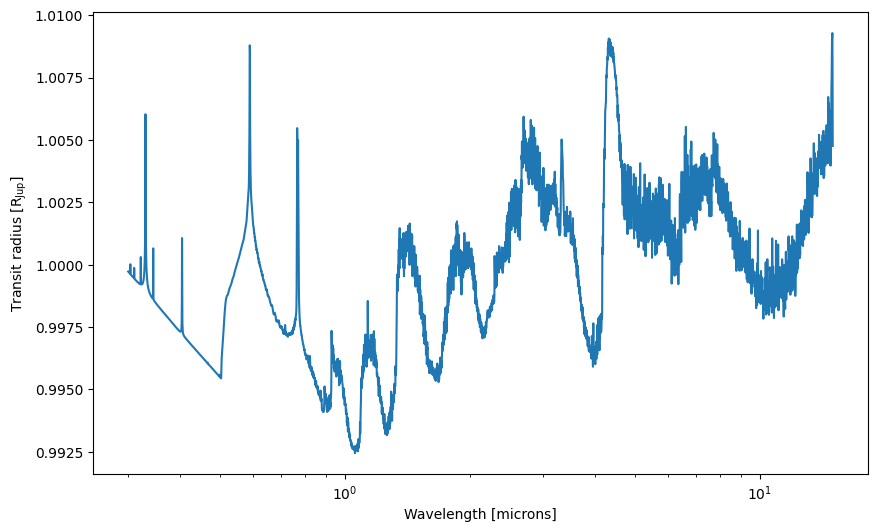

In [6]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths[0] * 1e4, transit_radii[0] / cst.r_jup_mean)
ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit radius [$\rm R_{Jup}$]')

### Calculating an emission spectrum: a more complex example

Emission spectra usually require more complex temperature profiles and mass fraction profiles than transmission spectra to accurately fit the data. Here we will introduce another default `SpectralModel` temperature profile (the [Guillot (2010)](http://adsabs.harvard.edu/abs/2010A%26A...520A..27G) temperature profile introduced in the gettting started section), as well as `SpectralModel`'s behaviour with mass fractions. We will also introduce more model parameters, relevant for emission spectra modelling.

In order to show the default behaviour of `SpectralModel` regarding mass fractions, we will use [equilibrium chemistry](./interpolating_chemical_equilibrium_abundances.ipynb) and filling species, and manually set an unreallistic H2O mass fraction profile.

#### Flux

Let's first generate our `SpectralModel`.

In [7]:
spectral_model = SpectralModel(
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na',
        'K'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    wavelength_boundaries=[0.3, 15],
    scattering_in_emission=True,  # replace do_scat_emis from pRT2
    # SpectralModel parameters
    # Planet parameters
    planet_radius=1 * cst.r_jup_mean,
    reference_gravity=10 ** 3.5,
    reference_pressure=1e-2,
    # Star, system, orbit
    is_observed=True,  # return the flux observed at system_distance
    is_around_star=True,  # if True, calculate a PHOENIX stellar spectrum and add it to the emission spectrum
    system_distance=10 * cst.s_cst.light_year * 1e2,  # m to cm, used to scale the spectrum
    star_effective_temperature=5500,  # used to get the PHOENIX stellar spectrum model
    star_radius=1 * cst.r_sun,  # used to get the star flux irradiating the planet
    orbit_semi_major_axis=0.01 * cst.au,  # used to get the star flux irradiating the planet
    # Temperature profile parameters
    temperature_profile_mode='guillot',
    temperature=1500,
    intrinsic_temperature=200,
    guillot_temperature_profile_gamma=0.4,
    guillot_temperature_profile_kappa_ir_z0=0.01,
    # Mass fractions
    use_equilibrium_chemistry=True,
    metallicity=3,  # times solar
    co_ratio=0.1,
    imposed_mass_fractions={
        'H2O': np.logspace(1, -12, 100)  # we use a H2O mass fraction > 1 to demonstrate how SpectralModel deals with it
    },
    filling_species={  # automatically fill the atmosphere with H2 and He, such that the sum of MMRs is equal to 1 and H2/He = 37/12, H2/Ne = 37/0.06
        'H2': 37, 
        'He': 12,
        'Ne': 0.06
    }
)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250mu.ktable

There are 2 parameters in particular that may require further explanation:
- `is_observed`: if `True`, return `flux * (planet_radius / system_distance) ** 2` instead of just `flux`. This is only used in emission mode.
- `is_around_star`: if `True`, calculate a PHOENIX stellar spectrum and use it to compute the emission spectrum. This is used only in emission mode. This has the same effect as using `Radtrans.compute_star_spectrum` in `Radtrans`. If `False`, no stellar spectrum is calculated and a `stellar_intensity` of 0 is assumed.

Let's now calculate the spectrum.

In [8]:
wavelengths, flux = spectral_model.calculate_spectrum(
    mode='emission',
    update_parameters=True  # this will build notably the temperature and mass fractions profile
)

Loading chemical equilibrium chemistry table from file '/home/dblain/petitRADTRANS/input_data/pre_calculated_chemistry/equilibrium_chemistry/equilibrium_chemistry.chemtable.petitRADTRANS.h5'... Done.
Loading PHOENIX star table in file '/home/dblain/petitRADTRANS/input_data/stellar_spectra/phoenix/phoenix.startable.petitRADTRANS.h5'... Done.


Now let's plot the spectrum.

Text(0, 0.5, 'Observerved planet flux, $F_{\\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

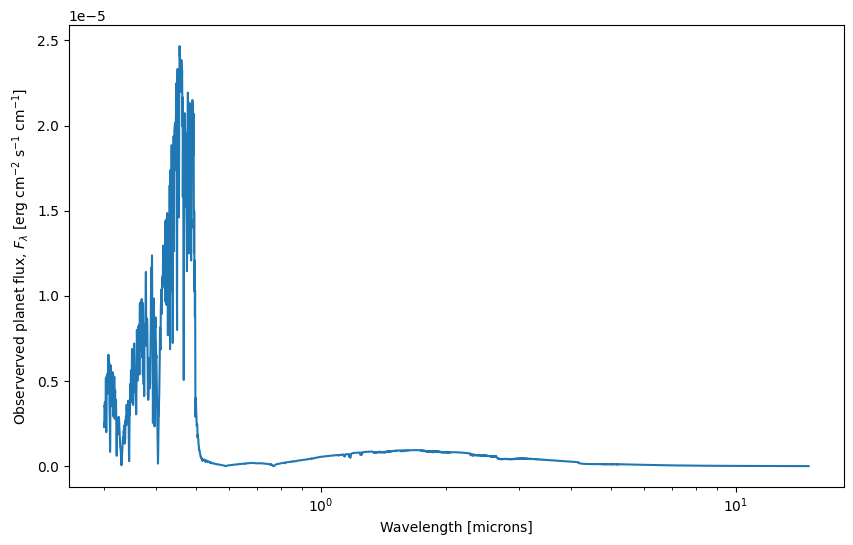

In [9]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths[0] * 1e4, flux[0])

ax.set_xscale('log')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Observerved planet flux, $F_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$ cm$^{-1}$]')

#### Temperature profile

<div class="alert alert-block alert-info">

The temperature profile calculation is controlled by the function `compute_temperature_profile`.
</div>

We can plot the temperature profile. This is the same Guillot temperature profile than in the getting started section.

Text(0, 0.5, 'P [bar]')

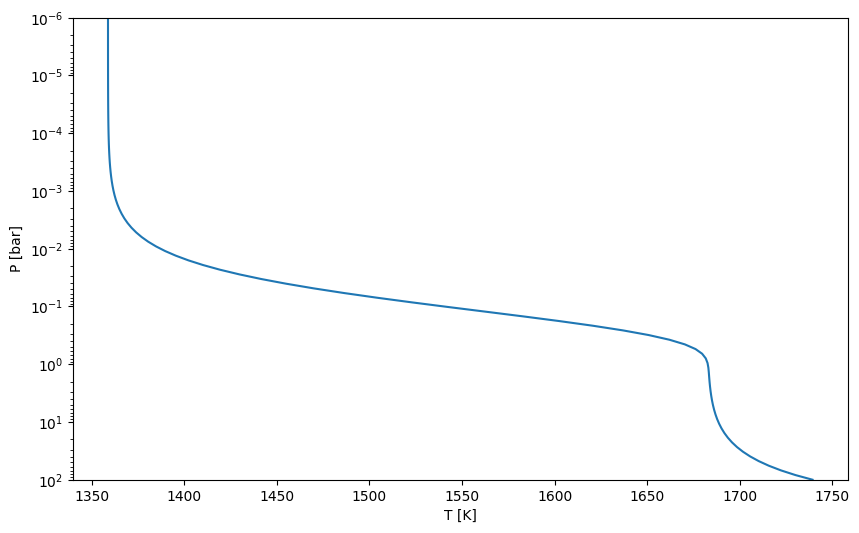

In [10]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(spectral_model.temperatures, spectral_model.pressures * 1e-6)
ax.set_yscale('log')
ax.set_ylim([1e2, 1e-6])
ax.set_xlabel('T [K]')
ax.set_ylabel('P [bar]')

#### Mass fractions

<div class="alert alert-block alert-info">

The mass fractions calculation is controlled by the function `compute_mass_fractions`.

To calculate the mean molar masses, the function used is `compute_mean_molar_masses`.
</div>

We can plot the mass fractions and see `SpectralModel`'s default behaviour.

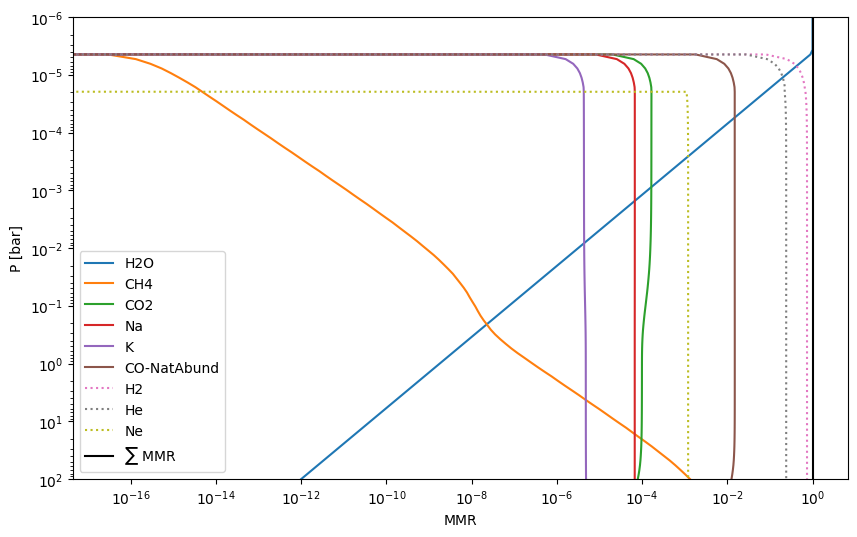

In [11]:
fig, ax = plt.subplots(figsize = (10,6))

for species, mass_fraction in spectral_model.mass_fractions.items():
    if species in spectral_model.line_species:
        ax.loglog(mass_fraction, spectral_model.pressures * 1e-6, label=species)

for species, mass_fraction in spectral_model.mass_fractions.items():
    if species in spectral_model.model_parameters['filling_species']:
        ax.loglog(mass_fraction, spectral_model.pressures * 1e-6, label=species, ls=':')

ax.loglog(np.sum(list(spectral_model.mass_fractions.values()), axis=0), spectral_model.pressures * 1e-6, label=r'$\sum$ MMR', color='k')
    
ax.set_ylim([1e2, 1e-6])
ax.set_xlabel('MMR')
ax.set_ylabel('P [bar]')
ax.legend()

Here we can see the priorities of `SpectralModel`, by default:
1. Always ensure that the sum of MMR is 1.
2. Ensure that the imposed mass fractions are strictly respected, unless their sum is > 1.
3. Ensure that the equilibrium chemistry mass fractions are respected, unless they conflict with the imposed mass fractions.
4. Ensure that the filling species ratios are respected, unless they conflict with the above.

While H2O is by default in the `PreCalculatedEquilibriumChemistryTable` (that we requested with `use_equilibrium_chemistry=True`), we overrided its mass fraction by using `imposed_mass_fractions`.

The species Ne is not in the `PreCalculatedEquilibriumChemistryTable`, in contrast with H2 and He. Hence, where H2O has become too abundant, Ne has been removed from the atmosphere to maintain the equilibrium chemistry relative mass fractions.

Note that while the key `'CO-NatAbund'` is not in the `PreCalculatedEquilibriumChemistryTable`, `SpectralModel` automatically linked it to the `'CO'` key.

We can also plot the mean molar masses (MMW).

Text(0, 0.5, 'P [bar]')

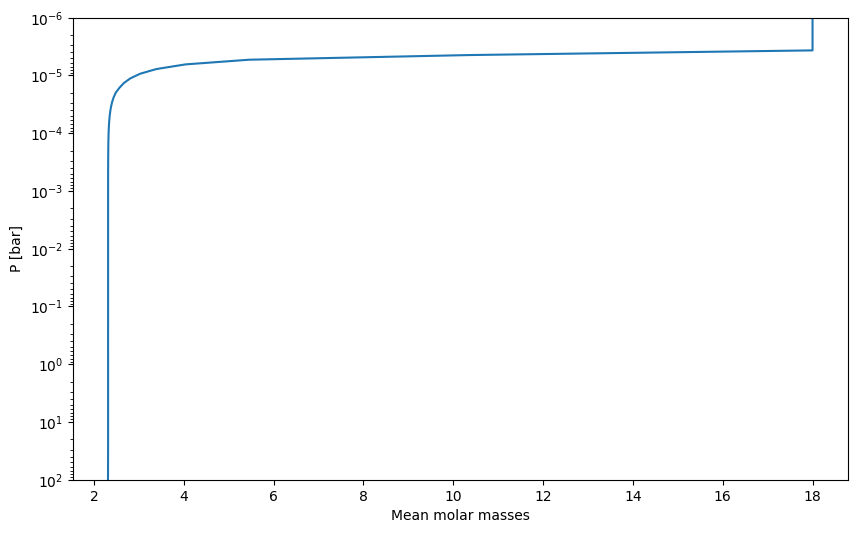

In [12]:
fig, ax = plt.subplots(figsize = (10,6))

ax.semilogy(spectral_model.mean_molar_masses, spectral_model.pressures * 1e-6, label=species)

ax.set_ylim([1e2, 1e-6])
ax.set_xlabel('Mean molar masses')
ax.set_ylabel('P [bar]')

Starting with the expected MMW for a jupiter-like H2/He atmosphere, as H2O become the dominant species, the MMW increases until it takes the H2O molar mass where the H2O mass fraction is 1.

## Calculating a time-varying high-resolution spectrum <a id='high_resolution'></a>

Let's now introduce more advanced `SpectralModel` features: the spectral modification parameters. We will do this by going through the calculation of a time-varying high-resolution spectrum.

### Introduction: Doppler-shifting and relative velocity <a id='doppler_shifting'></a>

`SpectralModel` can generate time-varying models. This includes most importantly changes in the relative velocity between the observer and the planet.

During the observation, the planet rotates around the star, so its radial velocity relative to the observer will change, Doppler-shifting the spectral lines. At low resolution this effect is usually negligible as the spectral lines are not resolved. At high resolution, taking into account for this effect is crucial.

But that's not all. We also need to take the motion of the star relative to the observer into account. In `SpectralModel`, this parameter is called `system_observer_radial_velocities`. It is usually divided into 2 components:
- The radial velocity between the planet's system barycenter and the barycenter of the solar system (`star_radial_velocity`, $V_\textrm{sys}$)
- The relative velocity between the observer and the barycenter of the solar system (`barycentric_velocities`, $V_\textrm{bary}$)

Often, we also add a correction term `rest_frame_velocity_shift` ($V_\textrm{rest}$) to the total velocity. This can be used as a proxy to model the effect of atmospheric winds, for example.

The `relative_velocities` ($V$) in `SpectalModel` are calculated following this equation:

\begin{equation}
V(t) = \sqrt{\frac{G M_\ast}{a_p}} \sin(i_p) \sin(2 \pi \phi(t)) + V_\textrm{sys}(t) + V_\textrm{bary}(t) + V_\textrm{rest}
\end{equation}

The first term is the planet radial velocity around its star relative to the observer. It is composed of the planet radial velocity semi-amplitude, often called $K_p$, multiplied by the $\sin$ of the orbital longitude (i.e. $2\pi$ time the **orbital phase**, $\phi$). In `SpectralModel`, $K_p$ can be given (`radial_velocity_semi_amplitude`), or calculated using:
- `star_mass` ($M_\ast$),
- `orbit_semi_major_axis` ($a_p$),
- `orbital_inclination` ($i_p$, optional, $90^\circ$ by default).

### Loading a `Planet`

It can be convenient to use the [`Planet` object](./planet.ipynb) to get the parameters we need. Note that this is not required.

In [13]:
from petitRADTRANS.planet import Planet

planet = Planet.get('HD 189733 b')

### Initializing a time-varying transmission spectrum <a id='initializing'></a>

We will generate mock data wavelengths and times below. We will assume that we observed 19 exposures. To keep things simple, we will assume that `star_radial_velocity` is fixed, and `barycentric_velocities` varies linearly. We will fix `rest_frame_velocity_shift` to -5 km.s-1, and let `SpectralModel` calculate $K_p$ for us.

In [14]:
from petitRADTRANS.math import resolving_space

n_exposures = 19

data_wavelengths = resolving_space(1.519, 1.522, 2e5) * 1e-4 # (cm) generate wavelengths at a constant resolving power
times = 0.85 * planet.transit_duration * (np.linspace(0, 1, n_exposures) - 0.5)  # covering 85% of the transit duration
orbital_phases = times / planet.orbital_period
mid_transit_time = 0  # (s)
star_radial_velocity = planet.star_radial_velocity  # (cm.s-1) V_sys
barycentric_velocities = np.linspace(-13.25e5, -13.55e5, times.size)  # (cm.s-1) V_bary

# Uncertainties assuming a S/N of 2000
data_uncertainties = 5e-4 * np.ones((1, n_exposures, data_wavelengths.size))

Now let's initalize our `SpectralModel`. We will add an opaque cloud layer at 100 mbar. Our instrument will have a resolving power of $R = 80\,000$.
<div class="alert alert-block alert-info">

**Argument `wavelength_boundaries`:** if you provide parameters such as the wavelengths of your data (`rebinning_wavelengths`), you no longer need to manually set `wavelength_boundaries`: `SpectralModel` will automatically calculate the optimal wavelengths boundaries for your data, taking into account the effect of time-varying Doppler-shift.
</div>

We will use `planet` to get some of the required parameters. 

We will introduce a few new model parameters, that will be described in more details in the next sections.

In [15]:
spectral_model = SpectralModel(
    # Radtrans parameters
    pressures=np.logspace(-6, 2, 100),
    line_species=[
        'CO-NatAbund', 
        'H2O' 
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    line_opacity_mode='lbl',
    line_by_line_opacity_sampling=4,
    # SpectralModel parameters
    # Planet parameters
    planet_radius=planet.radius,
    reference_gravity=planet.reference_gravity,
    reference_pressure=1e-2,
    star_radius=planet.star_radius,
    transit_duration=planet.transit_duration,
    orbital_period=planet.orbital_period,
    # Velocity paramters
    star_mass=planet.star_mass,
    orbit_semi_major_axis=planet.orbit_semi_major_axis,
    orbital_inclination=planet.orbital_inclination,
    rest_frame_velocity_shift=-5e5,  # (cm.s-1) V_rest
    system_observer_radial_velocities=star_radial_velocity - barycentric_velocities,
    # Temperature profile parameters
    temperature_profile_mode='isothermal',
    temperature=planet.equilibrium_temperature,
    # Cloud parameters
    opaque_cloud_top_pressure=1e-2,  # added opaque cloud
    # Mass fractions
    use_equilibrium_chemistry=False,
    imposed_mass_fractions={
        'CO-NatAbund': 1e-2,
        'H2O': 1e-3,
    },
    filling_species={
        'H2': 37,
        'He': 12
    },
    # Observation parameters
    rebinned_wavelengths=data_wavelengths,  # (cm) used for the rebinning, and also to set the wavelengths boundaries
    rebin_range_margin_power=4,  # used to set the wavelengths boundaries, adding a margin of ~1 Angstrom (1e-4 * ~1 µm)
    convolve_resolving_power=8e4,  # used for the convolution
    mid_transit_time=mid_transit_time,
    times=times,
    # Preparation parameters
    tellurics_mask_threshold=0.8,  # mask the fitted transmittances if it is below this value
    polynomial_fit_degree=2,  # degree of the polynomial fit
    uncertainties=data_uncertainties
)

Loading Radtrans opacities...
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/CO/C-O-NatAbund/C-O-NatAbund__HITRAN.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all CIA opacities
Successfully loaded 

To generate an exploitable time-varying model, we need to do several operations, in that order:
1. **Scale** the transit radii to the planet's star radius.
2. Doppler-**shift** the spectra at each exposure, in order to take the relative velocity (that needs to be calculated as well) between the planet and the observer into account.
3. Take into account the **transit light loss** due to the planet's ingress and egress.
4. **Convolve** the spectrum to the instrument's LSF.
5. **Rebin** the spectrum to the instrument's wavelengths.

With `SpectralModel`, these steps can be done easily, by adding some arguments to the `calculate_spectrum` function:

In [16]:
wavelengths_rebinned, transit_radii = spectral_model.calculate_spectrum(
    mode='transmission',
    update_parameters=True,
    scale=True,  # scale the spectrum
    shift=True,  # Doppler-shift the spectrum to the planet's radial velocities relative to the observer
    use_transit_light_loss=True,  # apply the effect of transit ingress and egress
    convolve=True,  # convolve to the instrument's resolving power
    rebin=True  # rebin to the instrument's wavelengths
)

Let's take a look at the outputs dimensions.

In [17]:
print(f"The shape of the rebinned wavelengths is {wavelengths_rebinned.shape}")
print(f"The shape of the rebinned transit_radii is {transit_radii.shape}")

The shape of the rebinned wavelengths is (1, 395)
The shape of the rebinned transit_radii is (1, 19, 395)


The `transit_radii` has one dimension to store respectively, the spectral **orders**, the **exposures** and the **wavelengths**. The wavelengths `wavelengths_rebinned` has one dimension to store respectively, the spectral **orders**, the **wavelengths**. In general, the instrument's wavelengths of reduced data is the same across exposures. 

The `data_wavelengths` had 1 dimension, so `SpectralModel` assumed that we had 1 order. To add more orders, `data_wavelengths` should have 2 dimensions, the first one corresponding to thespectral orders, and the second to the wavelengths.

Let's now plot the spectrum. Since we have one order, we can plot `transit_radii[0]`, which varies along exposures and wavelengths.

Text(0, 0.5, 'Orbital phase')

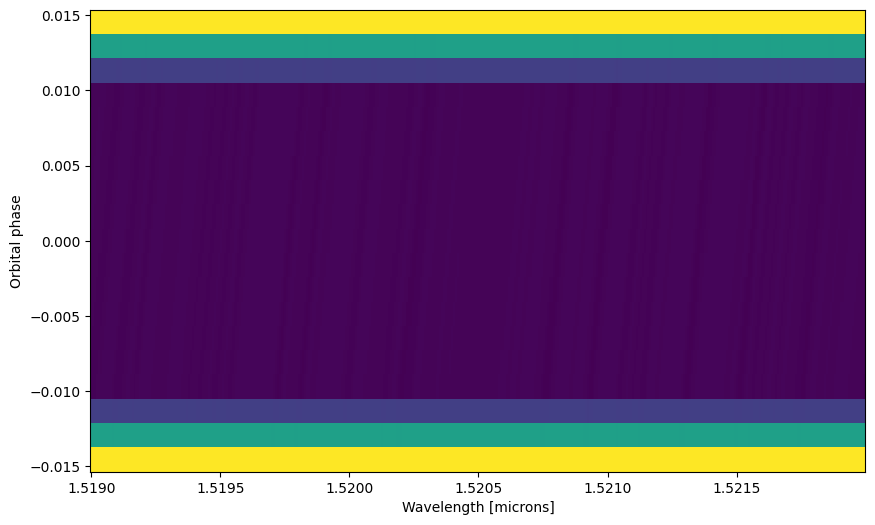

In [18]:
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(wavelengths_rebinned[0] * 1e4, orbital_phases, transit_radii[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Orbital phase')

<div class="alert alert-block alert-info">
    
Note that you can use the modifications arguments (`convolve`, `rebin`, etc.) in any combination (e.g., only `rebin`, only `scale` and `convolve`, etc.)
    
</div>

### Spectral modifications in details

In the sections below we will explain more in depth the effects of each `calculate_spectrum` new arguments.

#### No modification

If we calculated the transit radii as we did in the [intermediate usage section](#intermediate_usages), we would generate only a spectrum for one exposure.

Text(0, 0.5, 'Transit radius [cm]')

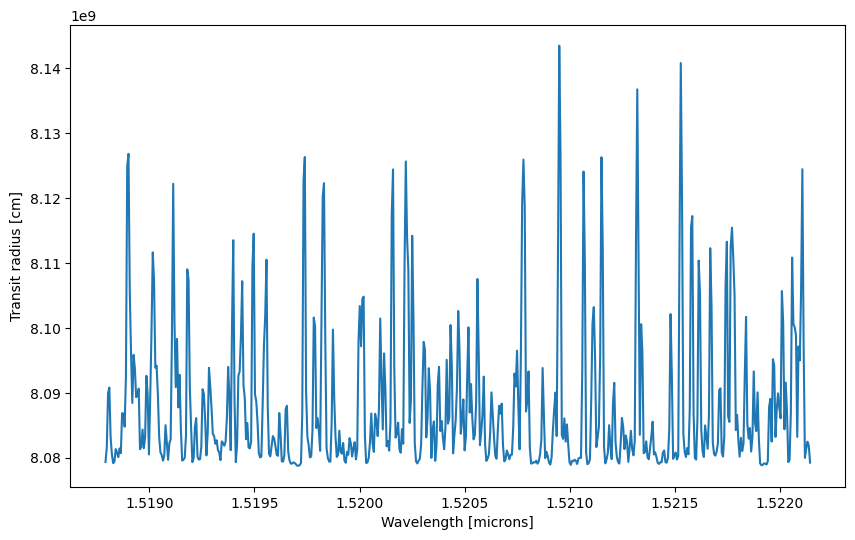

In [19]:
wavelengths, transit_radii_not_modified = spectral_model.calculate_spectrum(
    mode='transmission',
    update_parameters=True
)

# Plot the spectrum
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths[0] * 1e4, transit_radii_not_modified[0])  # [0] is used to get the 1st and only exposure
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit radius [cm]')

#### Scaling

<div class="alert alert-block alert-info">

The sclaing is controlled by the function `scale_spectrum`.
</div>

Here "scaling" refer to modifying the spectrum such as it is expressed relative to its planet's star's spectum. 

For transiting planets, the data collected are a combination of the star's spectrum ($F_\ast$) and the planet's spectrum ($F_p$). 

In emission (secondary eclipse), the observed spectum ($F_\mathrm{obs}$) can be expressed as:
\begin{equation}
F_{\mathrm{obs}} = F_\ast + F_p.
\end{equation}
Often, the stellar spectrum is acquired independently or modelled and is divided to the data, to obtain the **scaled** spectrum (after subtracting 1):
\begin{equation}
F_{\mathrm{scaled}} = F_p / F_\ast.
\end{equation}
In `SpectralModel`, the scaled emission spectrum is:
```python
spectrum /= star_observed_spectrum
```
where `star_observed_spectrum` is the re-binned spectrum obtained from the `compute_star_flux` function (PHOENIX model by default), observed at `system_distance` assuming a star radius of `star_radius`.

In transmission (primary eclipse), the observed spectum ($F_\mathrm{obs}$) can be expressed as a function of the planet (spectral) radius ($R_p$, aka the "transit radius") and the star radius ($R_\ast$):
\begin{equation}
F_{\mathrm{obs}} = F_\ast (1 - R_p / R_\ast)^2.
\end{equation}
Similarly, the **scaled** spectrum can be obtained by dividing with the star spectrum:
\begin{equation}
F_{\mathrm{scaled}} = 1 - (R_p / R_\ast)^2.
\end{equation}
In `SpectralModel`, the scaled transmission spectrum is:
```python
spectrum = 1 - (spectrum / star_radius) ** 2
```

To activate the scaling, set `scale=True`:

Text(0, 0.5, 'Scaled transit spectrum [arbitrary units]')

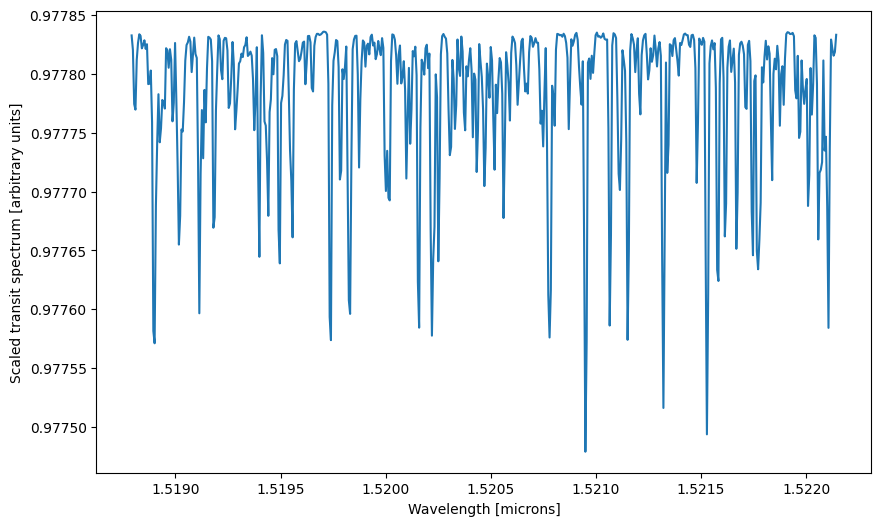

In [20]:
wavelengths, transit_radii_scaled = spectral_model.calculate_spectrum(
    mode='transmission',
    update_parameters=True,
    scale=True
)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths[0] * 1e4, transit_radii_scaled[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Scaled transit spectrum [arbitrary units]')

#### Shifting

<div class="alert alert-block alert-info">

The shifting is controlled by the function `shift_wavelengths`.
</div>

Now let's add Doppler-shifts the spectrum add the time dimension to our model. The explantions behind this step are in [this section](#doppler_shifting).

To activate the shifting, set `shift=True`:

In [21]:
wavelengths_shifted, transit_radii_shifted = spectral_model.calculate_spectrum(
    mode='transmission',  # can also be 'emission' to generate an emission spectrum, in that case, other model_parameters need to be provided
    update_parameters=True,  # the parameters that we set will be properly initialised
    scale=True,
    shift=True
)

The `transit_radii` and `wavelengths` shapes has been modified.

In [22]:
print(f"The shape of the shifted wavelengths is {wavelengths_shifted.shape}")
print(f"The shape of the shifted transit_radii is {transit_radii_shifted.shape}")

The shape of the shifted wavelengths is (19, 552)
The shape of the shifted transit_radii is (19, 552)


Now, instead of assuming 1 exposure as before, we have 1 spectrum for each of our 19 exposures, each with a spectrum Doppler-shifted at a different **relative velocity**. The relative velocities has been calculated by the built-in function `compute_relative_velocities`.

Now let's plot the relative velocities `SpectralModel` calculated.

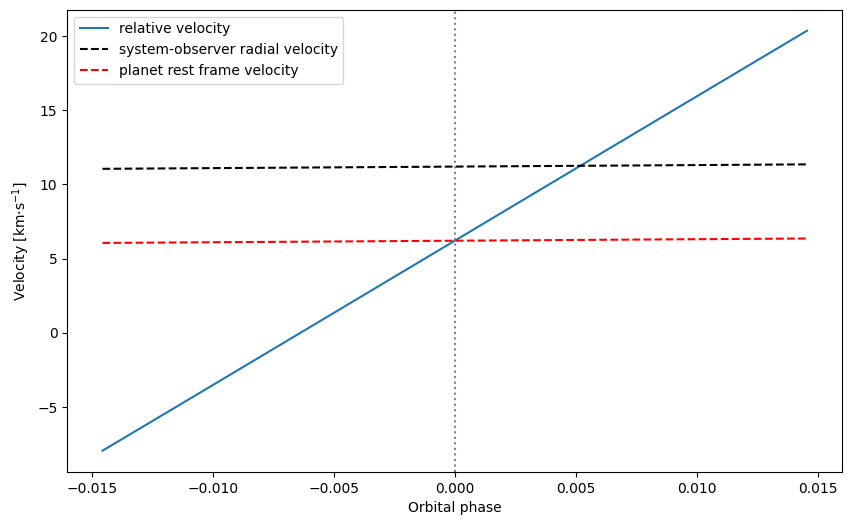

In [23]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(
    orbital_phases,
    spectral_model.model_parameters['relative_velocities'] * 1e-5,  # (cm.s-1 to km.s-1)
    label='relative velocity'
)

# Plot visual indicators
ax.plot(
    orbital_phases, 
    spectral_model.model_parameters['system_observer_radial_velocities'] * 1e-5,  # cm.s-1 to km.s-1
    ls='--', color='k', label='system-observer radial velocity'
)
ax.plot(
    orbital_phases, 
    (spectral_model.model_parameters['system_observer_radial_velocities'] + spectral_model.model_parameters['rest_frame_velocity_shift']) * 1e-5, 
    ls='--', color='r', label='planet rest frame velocity'
)

y_lim = ax.get_ylim()

ax.vlines(0, y_lim[0], y_lim[1], color='grey', ls=':')
ax.set_xlabel('Orbital phase')
ax.set_ylabel(r'Velocity [km$\cdot$s$^{-1}$]')
ax.set_ylim(y_lim)
ax.legend()

Now let's plot the spectra. We will plot 3 of them for clarity.

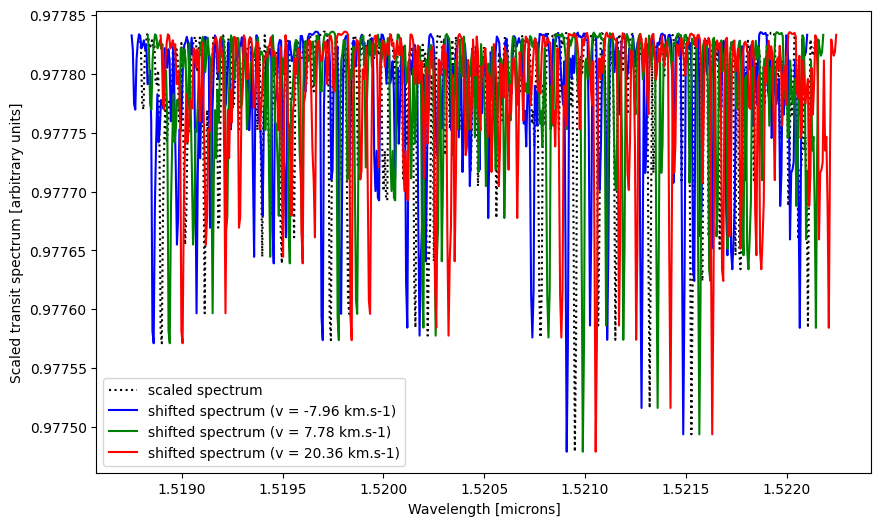

In [24]:
# Select 3 exposures to plot
exposures_to_plot = [
    0,
    10,
    -1
]

# Set the 3 spectrum colors in the plot
colors = [
    'b',
    'g',
    'r'
]

# Plot the un-shifted spectrum
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(
    wavelengths[0] * 1e4, transit_radii_scaled[0], 
    label='scaled spectrum', color='k', ls=':'
)

# Plot the shifted spectra
for i, exposure in enumerate(exposures_to_plot):
    ax.plot(
        wavelengths_shifted[exposure] * 1e4, transit_radii_shifted[exposure], 
        label=f"shifted spectrum (v = {spectral_model.model_parameters['relative_velocities'][exposure] * 1e-5:.2f} km.s-1)", color=colors[i]
    )
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Scaled transit spectrum [arbitrary units]')
ax.legend()

#### Convolving

<div class="alert alert-block alert-info">

The convolution is controlled by the function `convolve`.
</div>

Let's now add a convolution to the spectral modification, to better represent the instrument's LSF. By default, `SpectralModel` uses a Gaussian kernel and the parameter `convolve_resolving_power` that we provided. The built-in function for this operation is `convolve`.

To activate the shifting, set `convolve=True`:

In [25]:
wavelengths_shifted, transit_radii_shifted_convolved = spectral_model.calculate_spectrum(
    mode='transmission',  # can also be 'emission' to generate an emission spectrum, in that case, other model_parameters need to be provided
    update_parameters=True,  # the parameters that we set will be properly initialised
    scale=True,
    shift=True,
    convolve=True
)

Let's plot the spectrum at one exposure.

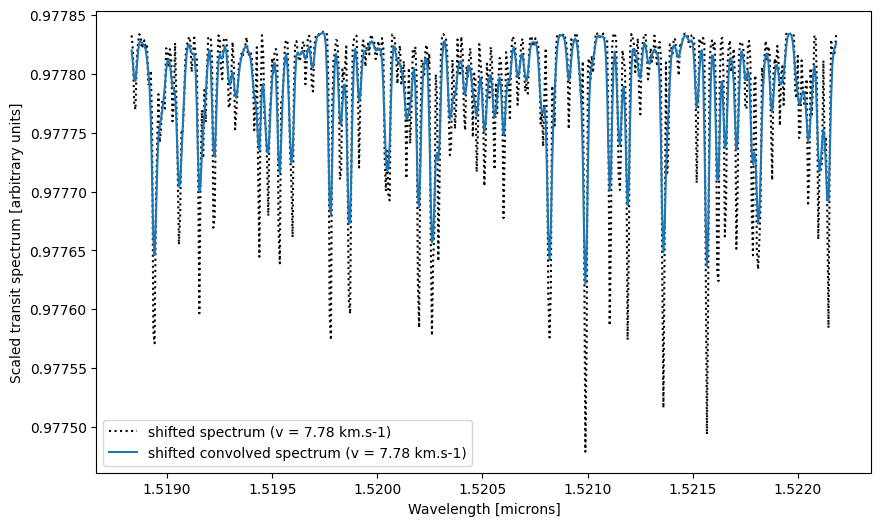

In [26]:
exposure_to_plot = 10 

# Plot the spectrum
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(
    wavelengths_shifted[exposure_to_plot] * 1e4, transit_radii_shifted[exposure_to_plot], 
    label=f"shifted spectrum (v = {spectral_model.model_parameters['relative_velocities'][exposure_to_plot] * 1e-5:.2f} km.s-1)", color='k', ls=':'
)
ax.plot(
    wavelengths_shifted[exposure_to_plot] * 1e4, transit_radii_shifted_convolved[exposure_to_plot], 
    label=f"shifted convolved spectrum (v = {spectral_model.model_parameters['relative_velocities'][exposure_to_plot] * 1e-5:.2f} km.s-1)"
)
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Scaled transit spectrum [arbitrary units]')
ax.legend()

#### Re-binning <a id='rebinning'></a>

<div class="alert alert-block alert-info">

The re-binning is controlled by the function `rebin_spectrum`.
</div>

Let's now re-bin the spectrum to the data wavelengths, in order to be able to compare our model with the data properly.

To activate the shifting, set `rebin=True`:

In [27]:
wavelengths_rebinned, transit_radii_rebinned = spectral_model.calculate_spectrum(
    mode='transmission',  # can also be 'emission' to generate an emission spectrum, in that case, other model_parameters need to be provided
    update_parameters=True,  # the parameters that we set will be properly initialised
    scale=True,
    shift=True,
    convolve=True,
    rebin=True
)

The shapes of `transit_radii` and `wavelengths` have changed again.

In [28]:
print(f"The shape of the rebinned wavelengths is {wavelengths_rebinned.shape}")
print(f"The shape of the rebinned transit radii is {transit_radii_rebinned.shape}")

The shape of the rebinned wavelengths is (1, 395)
The shape of the rebinned transit radii is (1, 19, 395)


Let's plot the spectra.

Text(0, 0.5, 'Orbital phase')

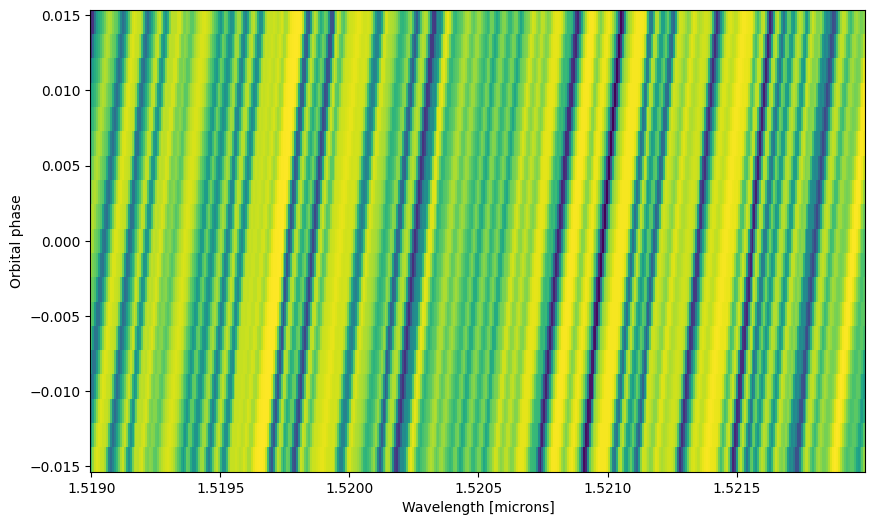

In [29]:
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(wavelengths_rebinned[0] * 1e4, orbital_phases, transit_radii_rebinned[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Orbital phase')

#### Transit effect

<div class="alert alert-block alert-info">

The transit effect is controlled by the function `compute_transit_fractional_light_loss`.
</div>

During a primary transit, the planet's disk is not always fully included inside the star's disk. This means that the transit depth during ingress and egress is smaller than during the full transit. In `SpectralModel`, this done with the built-in function `compute_transit_fractional_light_loss`, which is based on [Mandel & Agol 2002](https://www.doi.org/10.1086/345520) (Eq. 1), and uses the model parameters `transit_duration` ($T_{14}$) and `orbital_period` ($P$)..

<div class="alert alert-block alert-warning">

The limb-darkening effect is currently **not** taken into account.
</div>

We can calculate the spectrum to obtain the same result as at the [start of this section](#initializing).

Text(0.5, 1.0, 'Spectrum at 1.52050 microns')

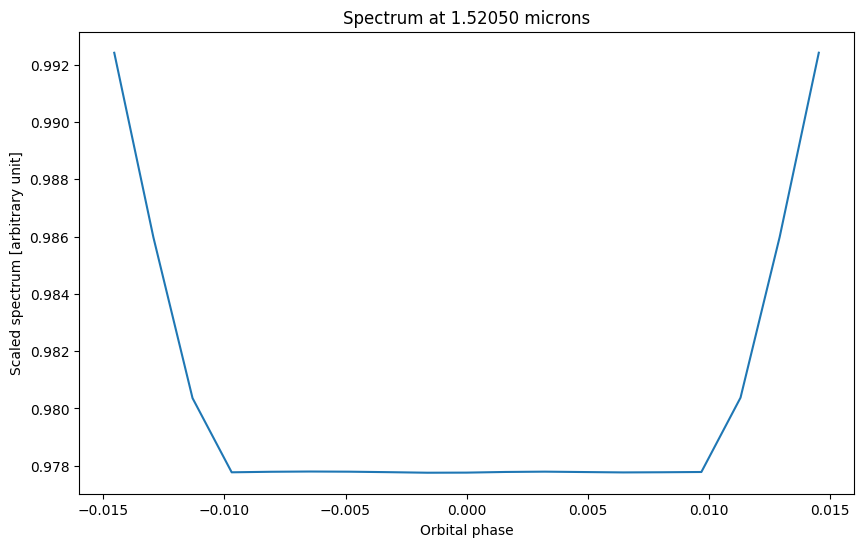

In [30]:
wavelengths_rebinned, transit_radii_final = spectral_model.calculate_spectrum(
    mode='transmission',  # can also be 'emission' to generate an emission spectrum, in that case, other model_parameters need to be provided
    update_parameters=True,  # the parameters that we set will be properly initialised
    scale=True,
    shift=True,
    use_transit_light_loss=True,
    convolve=True,
    rebin=True
)

# Plot the spectra across times at one wavelength
fig, ax = plt.subplots(figsize = (10,6))

wavelength_id = int(transit_radii_final.shape[-1] / 2)
ax.plot(orbital_phases, transit_radii_final[0, :, wavelength_id])
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Scaled spectrum [arbitrary unit]')
ax.set_title(f"Spectrum at {wavelengths_rebinned[0, wavelength_id] * 1e4:.5f} microns")

### Further modifications

This section goes into additional modification capabilities of `SpectralModel`, that are useful for tests or data analysis.

#### Simulating data <a id='simulating_data'></a>

To build simulated data, we can add telluric transmittances, setllar lines, instrumental deformations, and noise. To do this, we can make use of the following arguments:
- `telluric_transmittances`: telluric transmittances to combine with the spectrum. Those can make use of the `airmass` model parameter to automatically build time- and wavelength-varying transmittances. A good place to download telluric transitances is the [SKYCALC](https://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC) website. petitRADTRANS also has a module to directly download SKYCALC data, calculate the airmass, and even find the best day for your observations in the module `petitRADTRANS.cli.eso_skycalc_cli`.
- `telluric_transmittances_wavelengths`: wavelengths of the provided telluric transmittances.
- `instrumental_deformations`: time and wavelength matrix of the instrumental deformations. Must be of shape `(n_orders, n_exposures, n_wavelengths)`.
- `noise_matrix`: time and wavelength matrix of noise. Must be of shape `(n_orders, n_exposures, n_wavelengths)`.

The detailed `SpectralModel` modification flowchart in that case is:
1. `scale`, `shift`, then add the `transit_light_loss`,
2. Rebin the `telluric_transmittances` to the current wavelenghts, then multiply them to the spectra,
3. `convolve`, then `rebin` the spectra,
4. Multiply the spectra with the `instrumental_deformations`,
5. Add the `noise_matrix` to the spectra.

Below is an example, using simplisitc `telluric_transmittances`:

Text(0.5, 1.0, 'Simulated noisy data (noise time 20)')

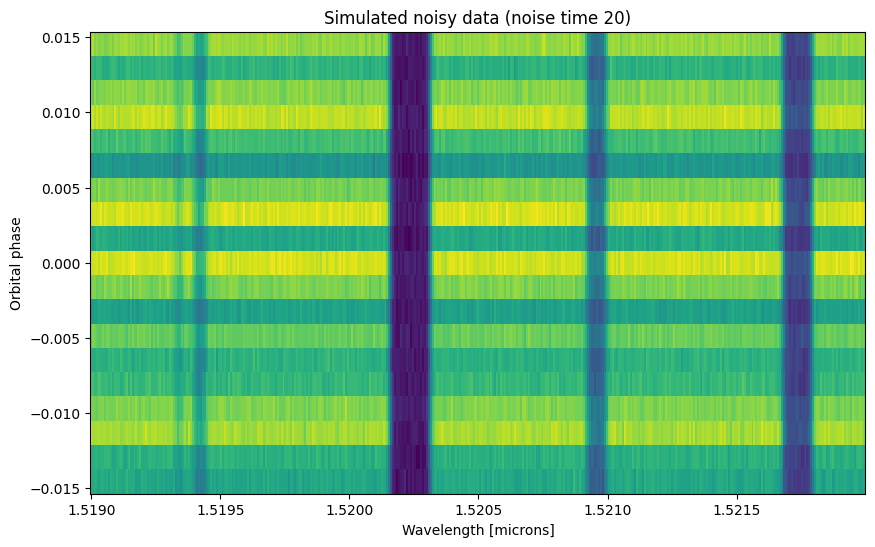

In [31]:
# High resolution telluric transmittances (typically downloaded from SKYCALC)
telluric_transmittances_wavelengths = resolving_space(1.515, 1.525, 1e6) * 1e-4
telluric_transmittances = np.ones(telluric_transmittances_wavelengths.size)

# Add simplisitc lines
telluric_transmittances[2850:2870] = 0.85
telluric_transmittances[2900:2930] = 0.7
telluric_transmittances[3400:3500] = 0.1
telluric_transmittances[3900:3950] = 0.5
telluric_transmittances[4400:4475] = 0.3

# Get airmass
mid_transit_time, _, _, _ = planet.calculate_mid_transit_time(
    observation_day=2458004.424877, # (JD)
    day2second=False  # if True, return the result in seconds since the start of the transit's day
)

airmass = planet.calculate_airmass(
    time=2458004.424877 + times / cst.s_cst.day,
    site_name='CAHA',
    time_format='jd'
)

spectral_model.model_parameters['airmass'] = airmass

# Random wavelength-constant instrumental deformations (typically unknown on real data), use a seed for reprooducibility
instrumental_deformations = (0.4 - 0.2) * np.random.default_rng(seed=12345).random(n_exposures) + 0.2
instrumental_deformations = np.repeat(instrumental_deformations[:, np.newaxis], data_wavelengths.size, axis=-1)

# Noise assuming a S/N of 1000
data_uncertainties = 5e-4 * np.ones((1, n_exposures, data_wavelengths.size))
noise_matrix = np.random.default_rng(seed=54321).normal(loc=0, scale=data_uncertainties)
noise_factor = 20  # for visual purposes

# Simulated data
wavelengths_rebinned, noisy_data = spectral_model.calculate_spectrum(
    mode='transmission',
    update_parameters=True,
    telluric_transmittances_wavelengths=telluric_transmittances_wavelengths,
    telluric_transmittances=telluric_transmittances,
    instrumental_deformations=instrumental_deformations,
    noise_matrix=noise_matrix * noise_factor,  # increases the noise to make it more visible in the figure
    scale=True,
    shift=True,
    use_transit_light_loss=True,
    convolve=True,
    rebin=True
)

# Plot the spectra
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(wavelengths_rebinned[0] * 1e4, orbital_phases, noisy_data[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Orbital phase')
ax.set_title(f"Simulated noisy data (noise time {noise_factor})")

Here you can see that the planet's spectral lines have become completely invisible, as we are dominated by the telluric lines. Note that the lines become slightly deeper as the orbital phase increase, this is the effect of the `airmass` we added above.

#### Preparing

<div class="alert alert-block alert-info">

The preparation step is controlled by the function `preparing_pipeline`.
</div>

The default petitRADTRANS preparing pipeline uses polynomial fits on wavelengths (for each exposure), then on times (for each wavelength) to remove the `instrumental_deformations` and `telluric_transmittances`.

We will build the same spectrum without noise so we can see the result on the lines, and use the preparing pipeline on it. This will simulate noiseless prepared data.

Text(0.5, 1.0, 'Prepared noiseless data')

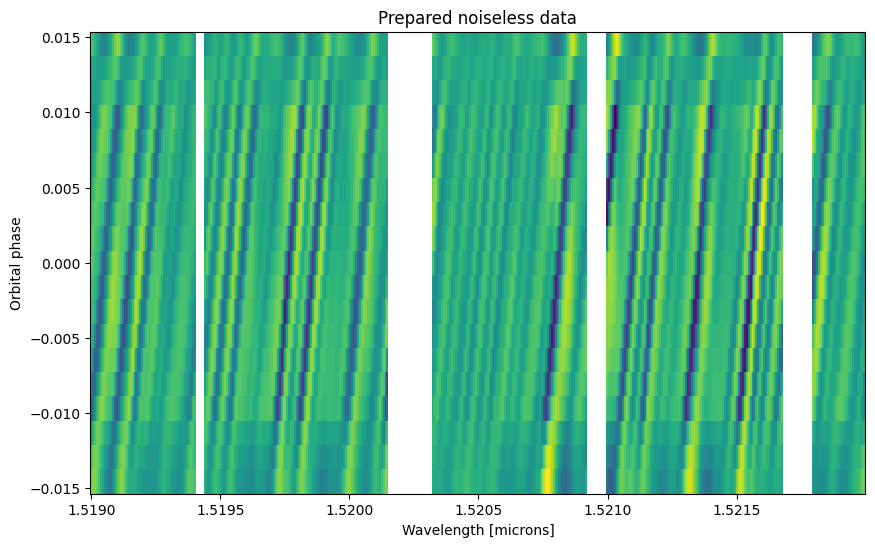

In [32]:
from petitRADTRANS.retrieval.preparing import polyfit

# Simulated noiseless data (instead you would load the data here)
data_wavelengths, data = spectral_model.calculate_spectrum(
    mode='transmission',  # can also be 'emission' to generate an emission spectrum, in that case, other model_parameters need to be provided
    update_parameters=True,  # the parameters that we set will be properly initialised
    telluric_transmittances_wavelengths=telluric_transmittances_wavelengths,
    telluric_transmittances=telluric_transmittances,
    instrumental_deformations=instrumental_deformations,
    noise_matrix=None,  # no noise so we can see the lines
    scale=True,
    shift=True,
    use_transit_light_loss=True,
    convolve=True,
    rebin=True,
    prepare=False  # if the data were loaded, a preparation could not be done rigth away
)

# The data and its uncertainties must be masked arrays
data = np.ma.masked_array(data)
data_uncertainties = np.ma.masked_array(data_uncertainties)

# You can mask for example invalid pixels, here we will mask nothing
data.mask = np.zeros(data.shape, dtype=bool)
data_uncertainties.mask = np.zeros(data_uncertainties.shape, dtype=bool)

# Prepare the loaded data
prepared_data, preparation_matrix, prepared_data_uncertainties = polyfit(
    spectrum=data,
    uncertainties=data_uncertainties,
    wavelengths=data_wavelengths,
    airmass=airmass,
    tellurics_mask_threshold=0.8,
    polynomial_fit_degree=2,
    full=True,
    apply_throughput_removal=True,
    apply_telluric_lines_removal=True
)

# Plot the prepared data
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(data_wavelengths[0] * 1e4, orbital_phases, prepared_data[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Orbital phase')
ax.set_title('Prepared noiseless data')

We get the lines again, but they are deformed by the preparing pipeline.


To get a prepared forward model, you can use the `prepare` argument of `calculate_spectrum`:

Text(0.5, 1.0, 'Prepared model')

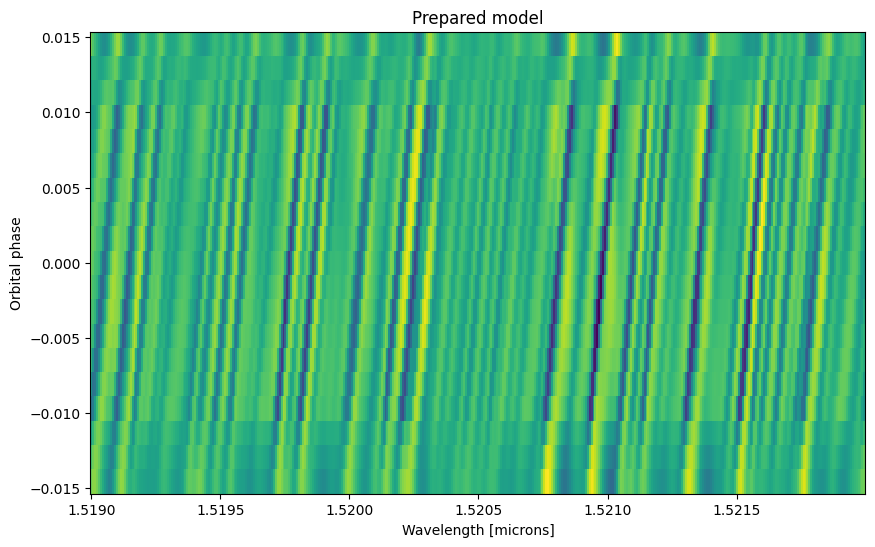

In [33]:
# Simulated prepared noiseless data
wavelengths_rebinned, prepared_model = spectral_model.calculate_spectrum(
    mode='transmission',  # can also be 'emission' to generate an emission spectrum, in that case, other model_parameters need to be provided
    update_parameters=True,  # the parameters that we set will be properly initialised
    scale=True,
    shift=True,
    use_transit_light_loss=True,
    convolve=True,
    rebin=True,
    prepare=True
)

# Plot the spectra
fig, ax = plt.subplots(figsize = (10,6))

ax.pcolormesh(wavelengths_rebinned[0] * 1e4, orbital_phases, prepared_model[0])
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Orbital phase')
ax.set_title('Prepared model')

<div class="alert alert-block alert-info">

In general, preparing pipelines performs better when the number of exposures and of wavelengths is higher, because the fit of the large trends in the data will be better.
</div>

To compare pipelines, the Bias Pipeline Metric (BPM, see [Blain et al. 2024](https://arxiv.org/abs/2402.14001)) can be used. It can be calculated via:

In [34]:
from petitRADTRANS.retrieval.preparing import bias_pipeline_metric

bpm = bias_pipeline_metric(
    prepared_true_model=prepared_model,
    prepared_mock_observations=prepared_data,
    mock_observations_preparation_matrix=preparation_matrix,
    mock_noise=None  # we are comparing with the noiseless simulated prepared data
)

print(f"BPM: {np.mean(np.abs(bpm)):.2e}")

BPM: 1.22e-06


The pipeline that has the mean absolute BPM the closest to 0 for a given set of simulated data can be seen as the most performant.

## Saving and loading
You can also save your `SpectralModel` for reproducibility or latter usage.

<div class="alert alert-block alert-warning">

**Caution:** currently `SpectralModel` does not save custom functions: it is assumed that the default `SpectralModel` has been used.
</div>


In [35]:
# Save the model
model_file = os.path.join('my_retrieval', 'my_model.h5')
spectral_model.save(model_file)

If you want to reload your `SpectralModel` with all of its `model_parameters`, simply use:

In [36]:
spectral_model_loaded = SpectralModel.load(model_file)

Converting pressures from CGS to bar for Radtrans input...
Loading Radtrans opacities...
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/CO/C-O-NatAbund/C-O-NatAbund__HITRAN.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/home/dblain/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.


We can check that the loaded `SpectralModel` is in the same state than the local one:

Text(0, 0.5, 'Transit spectrum (A.U.)')

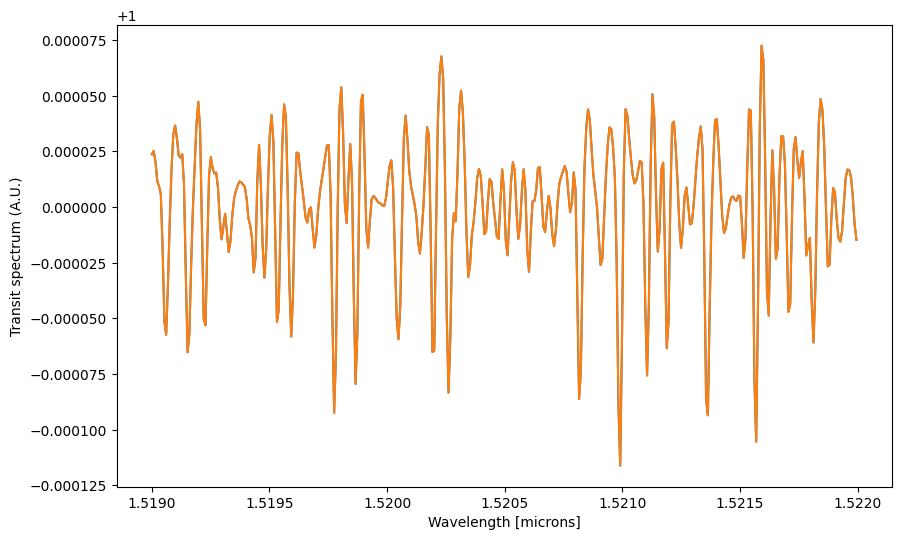

In [37]:
loaded_wavelengths, loaded_model = spectral_model_loaded.calculate_spectrum(
    **spectral_model_loaded.model_parameters['modification_parameters']
)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(loaded_wavelengths[0] * 1e4, loaded_model[0, 10], label='loaded_model')
ax.plot(wavelengths_rebinned[0] * 1e4, prepared_model[0, 10], label='saved_model')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Transit spectrum (A.U.)')

## Custom functions
All built-in `SpectralModel` functions can be customised.

Here is how to modify, for example the temperature profile function.

<div class="alert alert-block alert-warning">

**All** the customised `SpectralModel` functions **must** include a `**kwargs` argument.
</div>

Text(0.5, 1.0, 'New spectrum')

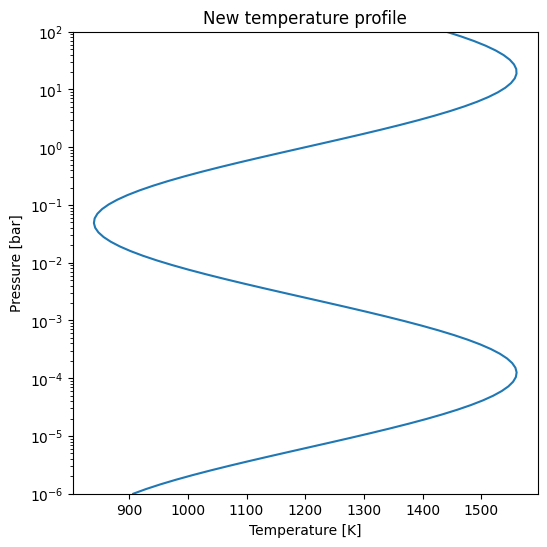

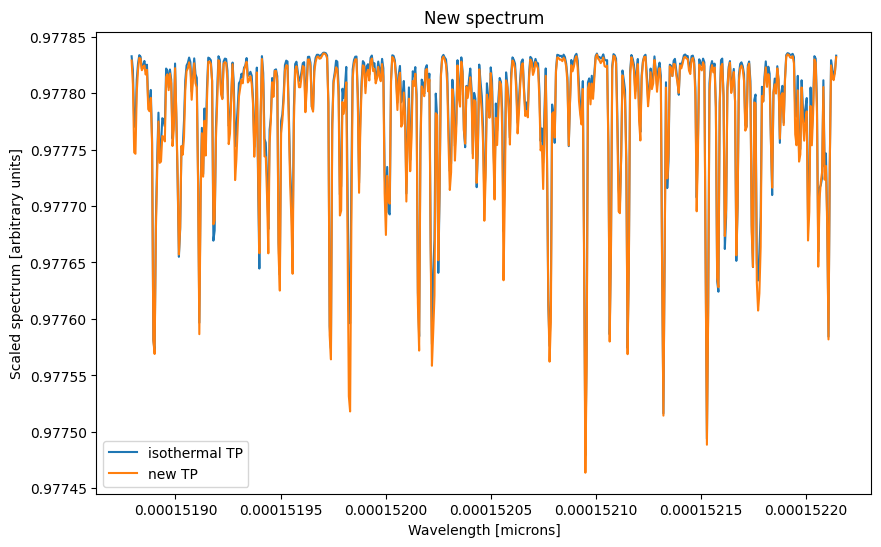

In [38]:
import copy

# Copy the SpectralModel
custom_spectral_model = copy.deepcopy(spectral_model)

# Set a new temperature profile function based on some top notch physics
def my_t_profile(pressures, my_parameter, x, **kwargs):  # the **kwargs is important, even if it's not used
    # Note that the "temperature" model parameter is not necessary, but in this context it could be used in place of "x"
    return x * (1 + 0.3 * np.sin(np.deg2rad(my_parameter * np.log(pressures))))

# Add necessary model parameters for the new TP model
# The new parameters are added here, but can also be added during instanciation just like any other model parameter
custom_spectral_model.model_parameters['my_parameter'] =  30
custom_spectral_model.model_parameters['x'] =  1200

# Modify the temperature profile of the model
custom_spectral_model.compute_temperature_profile = my_t_profile  

# Get the model model
wavelengths, transit_radii_new_tp = custom_spectral_model.calculate_spectrum(
    mode='transmission',
    update_parameters=True,
    scale=True
)

# Plot the new temperature profile
fig, ax = plt.subplots(figsize = (6,6))

ax.semilogy(custom_spectral_model.temperatures, custom_spectral_model.pressures * 1e-6)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [bar]')
ax.set_ylim(np.array([custom_spectral_model.pressures[0], custom_spectral_model.pressures[-1]]) * 1e-6)
ax.set_title('New temperature profile')

# Plot the new spectrum profile
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths[0], transit_radii_scaled[0], label='isothermal TP')
ax.plot(wavelengths[0], transit_radii_new_tp[0], label='new TP')
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel('Scaled spectrum [arbitrary units]')
ax.legend()
ax.set_title('New spectrum')